In [1]:
import torch
import pandas as pd
from torch.autograd import grad
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('./data/iris.data', index_col=None, header=None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
df = df.iloc[50:150]
df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)


# Assign features and target
X = torch.tensor(df[['x2', 'x3']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)


# Shuffling & train/test split
torch.manual_seed(1)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
X, y = X[shuffle_idx], y[shuffle_idx]
percent70 = int(shuffle_idx.size(0)*0.7)
X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]


# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

In [3]:
class Perceptron(torch.nn.Module):
    def __init__(self, num_features):
        super(Perceptron, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)
        
        # change random weights to zero
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        netinputs = self.linear(x)
        return netinputs.view(-1)
    
    
def train(model, x, y, num_epochs, learning_rate=0.01, seed=1, minibatch_size=10):
    cost = []
    torch.manual_seed(seed)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for e in range(num_epochs):
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:
            yhat = model.forward(x[minibatch_idx])
            loss = F.mse_loss(yhat, y[minibatch_idx])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Logging
        with torch.no_grad():
            yhat = model.forward(x)
            curr_loss = F.mse_loss(yhat, y)
            print('Epoch: %03d' % (e+1), end="")
            print(' | MSE: %.5f' % curr_loss)
            cost.append(curr_loss)

    return cost

In [4]:
model = Perceptron(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=20,
             learning_rate=0.01,
             seed=123,
             minibatch_size=10)

Epoch: 001 | MSE: 0.41487
Epoch: 002 | MSE: 0.33298
Epoch: 003 | MSE: 0.27267
Epoch: 004 | MSE: 0.22805
Epoch: 005 | MSE: 0.19511
Epoch: 006 | MSE: 0.17045
Epoch: 007 | MSE: 0.15206
Epoch: 008 | MSE: 0.13777
Epoch: 009 | MSE: 0.12705
Epoch: 010 | MSE: 0.11875
Epoch: 011 | MSE: 0.11222
Epoch: 012 | MSE: 0.10705
Epoch: 013 | MSE: 0.10296
Epoch: 014 | MSE: 0.09984
Epoch: 015 | MSE: 0.09728
Epoch: 016 | MSE: 0.09522
Epoch: 017 | MSE: 0.09351
Epoch: 018 | MSE: 0.09214
Epoch: 019 | MSE: 0.09104
Epoch: 020 | MSE: 0.09011


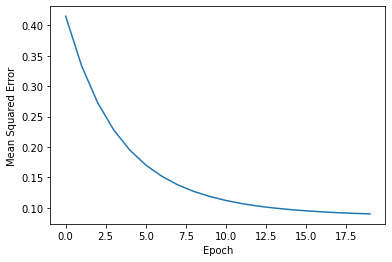

In [5]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [6]:
ones = torch.ones(y_train.size())
zeros = torch.zeros(y_train.size())
train_pred = model.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5, 
                 ones, 
                 zeros).int() == y_train).float())


ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5, 
                 ones, 
                 zeros).int() == y_test).float())


print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 94.29
Test Accuracy: 90.00
